# Raster Data Analysis in Python, Part 2

*February 22, 2024*

**Jumpstart Comprehension Check**

Given this GeoTransform tuple:

```python
gt = (-20015109.35, 463.3, 0.0, 10007554.7, 0.0, -463.3)
```

What are the coordinates of the upper-left hand corner of the image? What is the pixel size?

Now, suppose that we used the `Affine` class to create an affine transformation from this GeoTransform. 

```python
from affine import Affine
transform = Affine.from_gdal(*gt)
```


What is the output of the following?

```python
transform * (0, 0)
```

What about this one?

```python
transform * (1, 1)
```

In [3]:
from affine import Affine

gt = (-20015109.35, 463.3, 0.0, 10007554.7, 0.0, -463.3)
transform = Affine.from_gdal(*gt)

# This (0,0) will return the upper left geographic coordinate
transform * (0,0)

(-20015109.35, 10007554.7)

In [4]:
# This (1,0) will return the coordinate of the pixel to the right of the upper left corner
transform * (1,0) # Forward transofrmation: image to spatial coordinates

(-20014646.05, 10007554.7)

In [5]:
# If we subtract the x locations, we get the size of the pixel
-20015109.35 - -20014646.05

-463.30000000074506

In [7]:
# This will return the image coordinate from spatial coordinate. 
# Answer is given in row, column, like it would be indexed in an array
~transform * (-20014646.05, 10007554.7) # From spatial to image

(1.0, 0.0)

**What we discuss in today's lesson:**

- `np.apply_along_axis(function, axis, array)`, which applies a function along a specified axis, e.g., to calculate the maximum value along a time axis, for each pixel.
- `array >= 4000` or `array == -9999`, two examples of how to query a raster array; the result is a boolean array, of the same shape as `array`, with `True` values wherever the expression is true and `False` everywhere else.
- `array[array >= 4000]`, an example of how the boolean array can be used to *extract* values that match the conditional expression (e.g., all values greater than/equal to 4000 are returned).
- `array[array == -9999] = np.nan`, an example of how, instead of *extracting* values matching a conditional expression, we can *replace* values that match a conditional expression.

---

In [1]:
import requests
import numpy as np

content = requests.get('http://files.ntsg.umt.edu/data/GIS_Programming/data/NOAA_NCEP_CPC_gridded_deg0p5_1948-2022_NorthAmerica_74x97x211.float32')
data = np.frombuffer(content.content, dtype = np.float32)\
    .reshape((74, 97, 211))

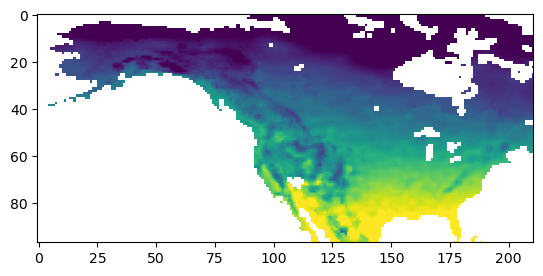

In [9]:
import matplotlib.pyplot as plt

plt.imshow(data[0], vmin = -10, vmax = 20)

In [10]:
data.shape

(74, 97, 211)

In [12]:
max_temp = np.nanmax(data, axis = 0)
max_temp.shape

C:\Users\by197116\AppData\Local\Temp\ipykernel_2912\2946807662.py:1: RuntimeWarning: All-NaN slice encountered
  max_temp = np.nanmax(data, axis = 0)


(97, 211)

In [13]:
# We can get the max temp in the same way
max_temp = data.max(axis = 0)
max_temp.shape

(97, 211)

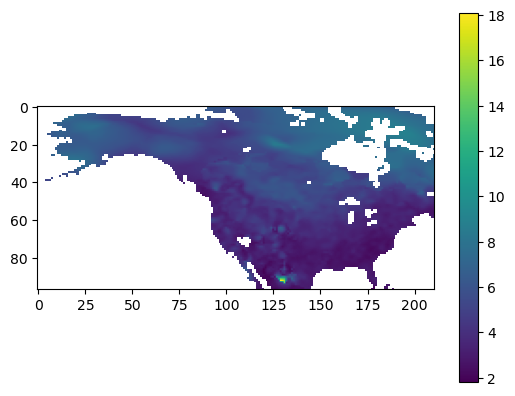

In [15]:
# This is how we would find the temp range of each pixel
rng_temp = data.max(axis = 0) - data.min(axis = 0)
plt.imshow(rng_temp)
plt.colorbar()

## Applying Functions to Axes

The arguments to `numpy.apply_along_axis()` are, in order:

- The function you want to apply
- The axis you want to apply the function over
- The array

For the second argument, it's helpful to remember how the `axis` argument works, from this diagram:

![](numpy-axis.jpg)

**When we write `np.apply_along_axis(max, 0, data)`, we are saying we want the function `max()` to be applied to slices along the 0th axis.** 

i.e., every time `max()` is called it receives a slice of the 0th axis which, in this case, is the years axis. You can prove this to yourself by trying out:

In [16]:
max_temp2 = np.apply_along_axis(np.max, 0, data)
max_temp2.shape

(97, 211)

In [17]:
# This does not work because it will return every T/F of the entire array
# NOTE: NaN is not equal to itself
max_temp == max_temp2

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [19]:
test = np.equal(max_temp, max_temp2)
test.shape

(97, 211)

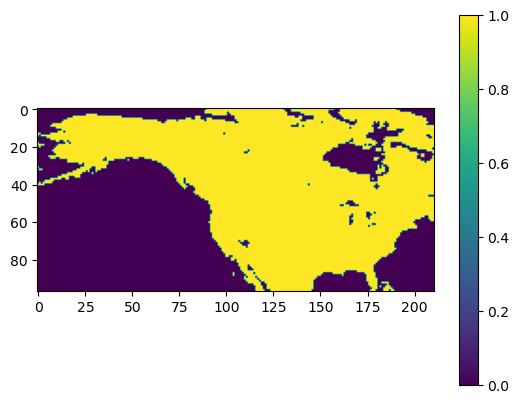

In [21]:
# There is green around the border of the continent because plt is smoothing the image
plt.imshow(test)
plt.colorbar()

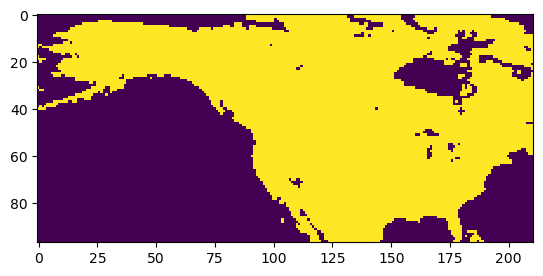

In [23]:
# We can use nearest neighbor as a sampling algorithm to tell it that we
# only want values 0 or 1 and the image should not be smoothed.

plt.imshow(test, interpolation = 'nearest')

In [25]:
# Define a function to give to apply_along_axis()
def rng(x):
    return np.max(x) - np.min(x)

rng_temp2 = np.apply_along_axis(rng, 0, data)
rng_temp2.shape

(97, 211)

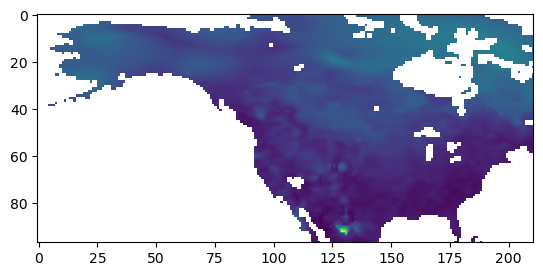

In [26]:
plt.imshow(rng_temp2)

In [29]:
# We can also use lambda functions to define the function in np.apply_along_axis
rng_temp3 = np.apply_along_axis(lambda x: np.max(x) - np.min(x), 0, data) # x is a pixel

In [37]:
from scipy import stats

def linear_trend(arr):
    # linregress(x, y) takes two arguments: y is regressed on x
    result = stats.linregress(np.arange(74), arr)
    return result.slope

trends = np.apply_along_axis(linear_trend, 0, data) # Since apply_along_axis returns 74 values, I can use
                                                    # the linear_trend function to take in 74 values

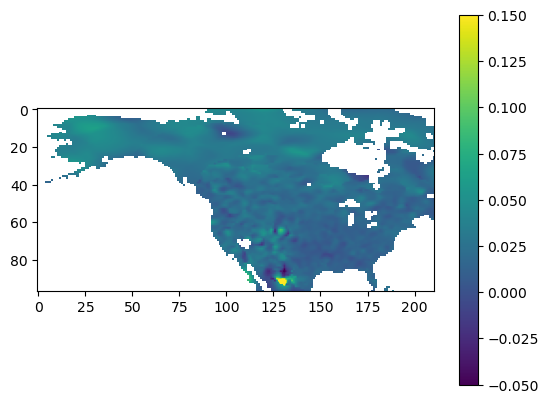

In [35]:
plt.imshow(trends, vmin = -0.05, vmax = 0.15)
plt.colorbar()
plt.show()

In [38]:
trends.shape

(97, 211)

In [40]:
max_trends = np.apply_along_axis(np.nanmax, 1, trends)
max_trends.shape

(97,)

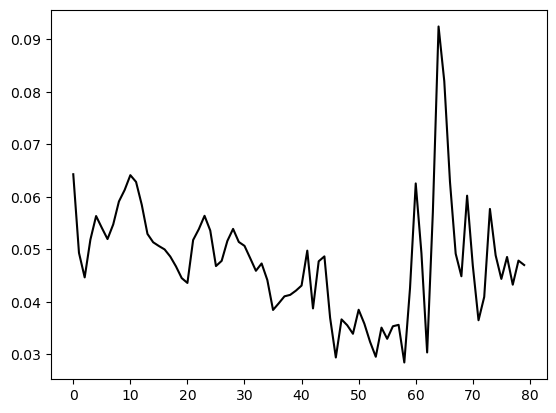

In [42]:
plt.plot(max_trends[0:80], 'k-')

---

## Array Masks and Zonal Statistics

In [44]:
from osgeo import gdal

ds_soc = gdal.Open('/vsicurl/http://files.ntsg.umt.edu/data/GIS_Programming/data/SPL4CMDL_Vv6040_20220901_SOC_9km.tiff')
soc = ds_soc.ReadAsArray()
soc.shape

(1624, 3856)

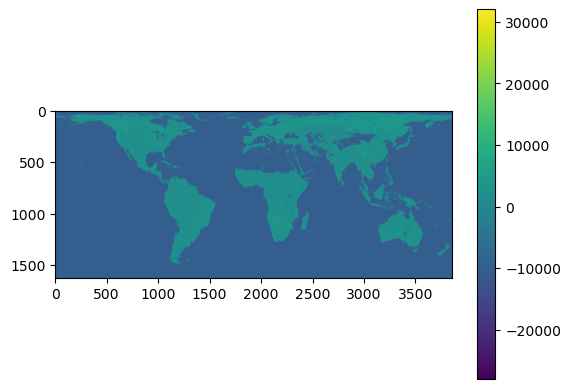

In [47]:
plt.imshow(soc)
plt.colorbar()

In [52]:
# We can see above that oceans have negative instead of NaN values
# So we want to pull out every value that is -9999 to change it to NaN
mask = soc == -9999

soc[mask] = np.nan

ValueError: cannot convert float NaN to integer

In [53]:
soc.dtype

dtype('int16')

In [54]:
soc = soc.astype(np.float32)

In [55]:
# Now that we have converted the dtype to float, we should be able to replace NaN
soc[mask] = np.nan

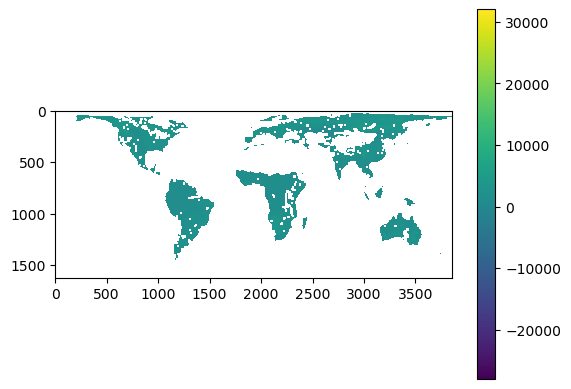

In [56]:
plt.imshow(soc)
plt.colorbar()

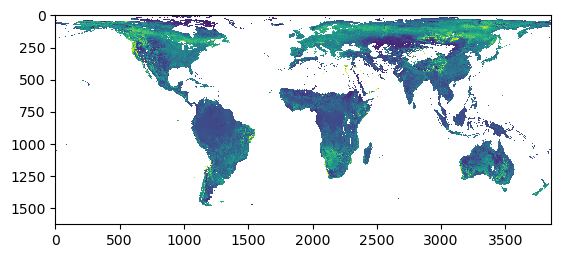

In [57]:
# We got swiss cheese above because plt is trying to smooth
# So we use nearest neighbor again
plt.imshow(soc, interpolation = 'nearest', vmin = 0, vmax = 6000)

### Handling NoData Values

Obviously, we need a way of telling our plotting library to ignore NoData values.

### Array Masks

#### NOTE!!!
Masked arrays are very slow in numpy. So rather than use a masked array, store and keep track of the mask!

In [58]:
soc[soc < 100]

array([    64.,     83.,     83.,     43.,     42.,     88.,     71.,
           71.,     98.,     92.,     78.,     93.,     98.,     97.,
           65.,     87., -27968.,     99.,     98.,     86.,     85.,
           86.,     91.,     82.,     81.], dtype=float32)

In [59]:
soc < 100

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [60]:
mask = soc < 1000
soc[mask].mean() # What is the mean of the pixels that match the condition of the mask?

760.6166

### Zonal Statistics

In [45]:
ds_plants = gdal.Open('/vsicurl/http://files.ntsg.umt.edu/data/GIS_Programming/data/SPL4CMDL_Vv6040_PFT_9km.tiff')
plants = ds_plants.ReadAsArray()
plants

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [9, 9, 9, ..., 9, 9, 9]], dtype=uint8)

Each of these integers represents a different plant community.

| Code | Plant Functional Type (PFT) |
|------|-----------------------------|
|     1| Evergreen Needleleaf        |
|     2| Evergreen Broadleaf         |
|     3| Deciduous Needleleaf        |
|     4| Deciduous Broadleaf         |
|     5| Shrub                       |
|     6| Grass                       |
|     7| Cereal Crop                 |
|     8| Broadleaf Crop              |


0 and 9 can be ignored.

In [68]:
# To ensure compatibility, we need to make sure they are the same shape
soc.shape == plants.shape

True

In [69]:
# To ensure compatibility, we need to make sure they are the same projection
ds_soc.GetProjection() == ds_plants.GetProjection()

True

In [72]:
ds_soc.GetGeoTransform() == ds_plants.GetGeoTransform()

True

In [74]:
results = []

for category in range(1, 9):
    avg = np.nanmean(soc[plants == category]) # Pull out the values of pixels per category
    results.append(avg)

results

[3643.8323,
 1595.7697,
 3701.677,
 2458.5247,
 2324.3328,
 2013.0952,
 2486.403,
 2565.3523]

Text(0.5, 0, 'Soil Organic Carbon (g C m-2)')

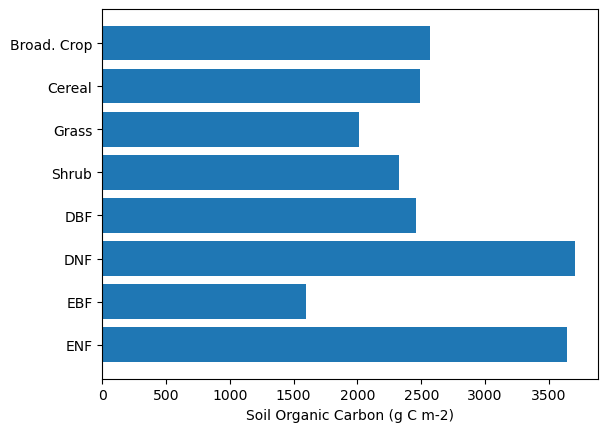

In [75]:
# The above data can and should be stored as UNSIGNED INTEGER because they are only
# a few non-negative integers
labels = ('ENF', 'EBF', 'DNF', 'DBF', 'Shrub', 'Grass', 'Cereal', 'Broad. Crop')
plt.barh(labels, results)
plt.xlabel('Soil Organic Carbon (g C m-2)')

---

## Challenge: Raster Reclassification

Often when working with categorical data, we want to change the classification system, either splitting or combining existing classes.

**Starting with the `plants` array, create a new categorical array that has only:**

- Broadleaf forest
- Needleleaf forest
- Shrub
- Grass
- Croplands

**Then, use this reclassified array to calculate the land area in each category.** The `plants` array comes from a raster with an equal-area projection, where each pixel is 9 km by 9 km.

---

## More Resources

- [GDAL Python API documentation](https://gdal.org/api/python/osgeo.gdal.html)
- [GDAL-OGR Cookbook](https://pcjericks.github.io/py-gdalogr-cookbook/index.html)